# Curso de Big Data

## Trabajo Práctico 3

### Samuel Arispe, Gonzalo Ochoa y Facundo Valle Quintana

### Reglas de formato y presentación
- El trabajo debe estar bien comentado (utilizando #) para que el código sea fácil de entender por sus compañeros y profesores.

- El mismo debe ser completado en este Jupyter Notebook y entregado como tal, es decir en un archivo .ipynb


### Fecha de entrega:
Domingo 5 de noviembre a las 23:59hs

### Contenidos:


Analizar el problema del no reporte de ingresos en las encuestas de hogares y cómo eso afecta la medición de la tasa de pobreza. Se profundizará en el análisis de esta temática con los nuevos métodos vistos en clase para identificar individuos sin reporte de ingresos.

### Modalidad de entrega
- Al finalizar el trabajo práctico deben hacer un último <i>commit</i> en su repositorio de GitHub con el mensaje “Entrega final del tp”.

- Asegurense de haber creado una carpeta llamada TP3. Deben entregar el código (jupyter notebook).

- También deben completar el link de su repositorio -para que pueda ser clonado y corregido- en la siguiente <a href="https://docs.google.com/spreadsheets/d/1v8Sv2TSzpK6mxjm3mmdnhmkk0qiyGFNj/edit#gid=1820558252">google sheet</a>

- La última versión en el repositorio es la que será evaluada. Por lo que es importante que:
    - No completen la google sheet hasta no haber terminado y estar seguros de que han hecho el <i>commit y push</i> a la versión final que quieren entregar. Debido a que se pueden tomar hasta 3 días de extensión a lo largo del curso, no se  corregirán sus tareas hasta no ver el link en la google sheet.\
    
    - No hagan nuevos <i>push</i> despues de haber entregado su versión final. Esto generaría confusión acerca de que versión es la que quieren que se les corrija.

### Reglas de formato y presentación

- El trabajo se debe entregar como Jupyter Notebook. Se espera una buena redacción en la resolución del práctico.

- Identifiquen claramente a qué inciso corresponde cada comando y, cuando sea necesario, usen bloques de texto para detallar sus respuestas.

- Importante: Todos los miembros del equipo deben haber hecho al menos un <i> commit </i> durante la realización del TP para asegurar que todos hayan aportado a su resolución.

## Parte I: Análisis de la base de hogares y cálculo de pobreza

Ahora que ya se han familiarizado con la Encuesta Permanente de Hogares (EPH) y
con la tabla de adulto equivalente, vamos a complejizar un poco la construcción del índice de pobreza. Lo calcularemos a nivel de hogares, con sus respectivos factores de expansión y realizaremos una limpieza de la base con mayor dedicación.
A continuación, complementamos el trabajo hecho en el TP2 usando la encuesta a
nivel hogares de la EPH.

#### 1. Exploren el diseño de registro de la base de hogar: a priori, ¿qué variables creen que pueden ser muy predictivas de pobreza y que sería muy útil incluir para perfeccionar el ejercicio del TP2?

Respuesta: A la hora de perfeccionar la predicción de la pobreza del TP2, consideramos que las siguientes variables pueden ser relevantes:

1. <b>Identificación</b>: retendríamos todas las variables, ya que nos permiten ubicar espacial y temporalmente a la pobreza.
<br>

2. <b>Características de la vivienda</b>: retendríamos las siguientes variables: IV1, IV2, V4, IV7, IV8, IV10, IV11, IV12_3, dado que identifican considiciones habitacionales subóptimas, que son claves determinantes de la pobreza siguiendo la lógica de Amartya Sen.
<br>

3. <b>Características habitacionales</b>: retendríamos las siguientes variables: II1, II3, II8, II9, V1, V2, V4, V5, V6, V12, V19_A, V19_B, IX_ToT, ITF, DECIFR, IPCF, DECCFR. Este conjunto de variables nos permite indagar sobre las dimensiones del hogar, el funcionamiento de sus baños y la fuente de los ingresos familiares lo que nos permite identificar a las personas más vulnerables.

#### 2. Descarguen la base de microdatos de la EPH correspondiente al primer trimestre de 2023 (la base de hogares se llama usu hogar T123.xls). Importen los datos de la encuesta de hogar y, al igual que en el TP2, conserven sólo las observaciones que corresponden a los aglomerados de Ciudad Autónoma de Buenos Aires o del Gran Buenos Aires.

In [1]:
# Importamos paquetes.

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Repetimos lo del ejercicio 2:

data = pd.read_excel("usu_hogar_T123.xlsx")
data_gba = data[data['AGLOMERADO'].isin([32, 33])]


#### 3. Unan la tabla de la encuesta individual con la de la encuesta de hogar.

In [10]:
# Unimos las dos bases de datos, posible gracias a las dos columnas CODUSU y NRO_HOGAR que nos permiten identificar cada hogar.

data_indiv = pd.read_excel("usu_individual_T123.xlsx")

data_merged = pd.merge(data_gba, data_indiv, on=['CODUSU', 'NRO_HOGAR'], how='left', suffixes=('', '_y'))
data_merged

,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,REALIZADA,REGION,MAS_500,AGLOMERADO,PONDERA,IV1,...,PDECIFR_y,ADECIFR_y,IPCF_y,DECCFR_y,IDECCFR_y,RDECCFR_y,GDECCFR_y,PDECCFR_y,ADECCFR_y,PONDIH_y
0,TQRMNORVYHMOTSCDEIJAH00802517,2023,1,1,1,1,S,33,1066,1,...,NaN,12,0.0,12,NaN,12,12.0,NaN,12,0
1,TQRMNORVYHMOTSCDEIJAH00802517,2023,1,1,1,1,S,33,1066,1,...,NaN,12,0.0,12,NaN,12,12.0,NaN,12,0
2,TQRMNOSQRHLLTTCDEIJAH00719390,2023,1,1,1,1,S,33,2270,2,...,NaN,5,79000.0,6,NaN,6,6.0,NaN,7,4733
3,TQRMNOSQRHLLTTCDEIJAH00719390,2023,1,1,1,1,S,33,2270,2,...,NaN,5,79000.0,6,NaN,6,6.0,NaN,7,4733
4,TQSMNOSQRHLLTTCDEIJAH00719389,2023,1,1,1,1,S,33,2161,1,...,NaN,3,96000.0,7,NaN,7,7.0,NaN,8,2672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7614,TQRMNOSSQHKOOMCDEIJAH00802644,2023,1,1,1,1,S,33,3381,1,...,NaN,1,14750.0,1,NaN,1,1.0,NaN,1,4548
7615,TQRMNOSSQHKOOMCDEIJAH00802644,2023,1,1,1,1,S,33,3381,1,...,NaN,1,14750.0,1,NaN,1,1.0,NaN,1,4548
7616,TQRMNOSSQHKOOMCDEIJAH00802644,2023,1,1,1,1,S,33,3381,1,...,NaN,1,14750.0,1,NaN,1,1.0,NaN,1,4548
7617,TQRMNORYPHJKNPCDEIJAH00794297,2023,1,1,1,1,S,33,521,1,...,NaN,1,32000.0,2,NaN,2,2.0,NaN,2,896


#### 4. Generen sus propias funciones para limpiar la base de datos o, si deciden utilizar funciones existentes en paquetes como numpy y pandas, mencionen cúales usarán y de qué paquetes son.

In [11]:
# Data Cleaning #
#################

# Creamos función que elimina columnas duplicadas

def drop_duplicated_columns(df):
    columns_to_drop = [col for col in df.columns if col.endswith("_y")] # identifica las columnas duplicadas del merge anterior, que terminan en "_y"
    
    df_dropped = df.drop(columns=columns_to_drop, axis =1)
    
    return df_dropped

In [12]:
df_cleaned_col = drop_duplicated_columns(data_merged)

In [13]:
# Buscamos los Nans.

def find_columns_with_nan(df):
    nan_columns = df.columns[df.isna().any()].tolist()
    return nan_columns

# Find columns with NaN values
columns_with_nan = find_columns_with_nan(df_cleaned_col)
print("Columns with NaN values:", columns_with_nan)

column_names = df_cleaned_col.columns.to_list()
print(column_names)

# Podemos ver que hay muchísimas columnas con NaNs, por lo que no es recomendable droppear las columnas directamente. 
# Optamos por eliminar columnas con una cantidad de NaN superior a 75% de 


Columns with NaN values: ['IV1_ESP', 'IV3_ESP', 'IV7_ESP', 'II7_ESP', 'II8_ESP', 'IDECIFR', 'PDECIFR', 'IDECCFR', 'PDECCFR', 'CH08', 'CH14', 'CH15_COD', 'CH16_COD', 'IMPUTA', 'PP03C', 'PP03D', 'PP3E_TOT', 'PP3F_TOT', 'PP03G', 'PP03H', 'PP03I', 'PP03J', 'INTENSI', 'PP04A', 'PP04B_COD', 'PP04B1', 'PP04B2', 'PP04B3_MES', 'PP04B3_ANO', 'PP04B3_DIA', 'PP04C', 'PP04C99', 'PP04D_COD', 'PP04G', 'PP05B2_MES', 'PP05B2_ANO', 'PP05B2_DIA', 'PP05C_1', 'PP05C_2', 'PP05C_3', 'PP05E', 'PP05F', 'PP05H', 'PP06A', 'PP06C', 'PP06D', 'PP06E', 'PP06H', 'PP07A', 'PP07C', 'PP07D', 'PP07E', 'PP07F1', 'PP07F2', 'PP07F3', 'PP07F4', 'PP07F5', 'PP07G1', 'PP07G2', 'PP07G3', 'PP07G4', 'PP07G_59', 'PP07H', 'PP07I', 'PP07J', 'PP07K', 'PP08D1', 'PP08D4', 'PP08F1', 'PP08F2', 'PP08J1', 'PP08J2', 'PP08J3', 'PP09A', 'PP09A_ESP', 'PP09B', 'PP09C', 'PP09C_ESP', 'PP10A', 'PP10C', 'PP10D', 'PP10E', 'PP11A', 'PP11B_COD', 'PP11B1', 'PP11B2_MES', 'PP11B2_ANO', 'PP11B2_DIA', 'PP11C', 'PP11C99', 'PP11D_COD', 'PP11G_ANO', 'PP11G_MES

In [15]:
# Creamos una función para cuantificar los NaNs.

def count_and_percentage_of_nans(df):
    nan_info = pd.DataFrame({
        'Column Name': df.columns,
        'Number of NaNs': df.isna().sum(),
        '% of NaNs': (df.isna().sum() / len(df) * 100)
    })

    return nan_info

nan_info = count_and_percentage_of_nans(df_cleaned_col)

nan_info # Lamentablemente este método no nos permite visualizar la información relevante de los NaNs.

          Column Name  Number of NaNs  % of NaNs
CODUSU         CODUSU               0        0.0
ANO4             ANO4               0        0.0
TRIMESTRE   TRIMESTRE               0        0.0
NRO_HOGAR   NRO_HOGAR               0        0.0
REALIZADA   REALIZADA               0        0.0
...               ...             ...        ...
V12_M           V12_M               0        0.0
V18_M           V18_M               0        0.0
V19_AM         V19_AM               0        0.0
V21_M           V21_M               0        0.0
T_VI             T_VI               0        0.0

[242 rows x 3 columns]


,Column Name,Number of NaNs,% of NaNs
CODUSU,CODUSU,0,0.0
ANO4,ANO4,0,0.0
TRIMESTRE,TRIMESTRE,0,0.0
NRO_HOGAR,NRO_HOGAR,0,0.0
REALIZADA,REALIZADA,0,0.0
...,...,...,...
V12_M,V12_M,0,0.0
V18_M,V18_M,0,0.0
V19_AM,V19_AM,0,0.0
V21_M,V21_M,0,0.0


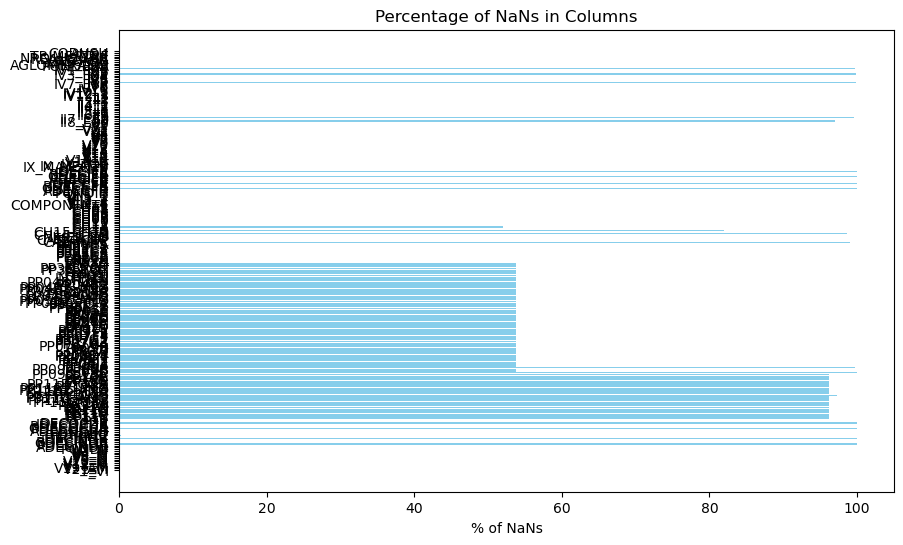

In [16]:
# Realizamos entonces un análisis gráfico de las columnas con NaNs: miramos sus % de Nans respecto a las observaciones totales.

plt.figure(figsize=(10, 6))
plt.barh(nan_info['Column Name'], nan_info['% of NaNs'], color='skyblue')
plt.xlabel('% of NaNs')
plt.title('Percentage of NaNs in Columns')
plt.gca().invert_yaxis()
plt.show()

# Como podemos ver, hay una importante proporción de NaNs en cada columna.

In [27]:
#Ahora, procedemos a cuantificar estos Nans, para poder determinar que estrategia seguir.

# Calculamos los deciles de los NaNs como porcentajes.

deciles = [10, 20, 30, 40, 50, 60, 70, 80, 90]
percentiles = np.percentile(nan_info['% of NaNs'], deciles)

# Los mostramos, usando el operador zip que itera y matchea los percentiles calculados con los deciles especificados.
for decile, percentile_value in zip(deciles, percentiles):
    print(f" En el decil {decile} tenemos un {percentile_value}% de NaNs.")
    
# Podemos ver que la mayoría 50% - 60% de las columnas tienen un 53% de NaNs. 

# Decidimos entonces descartar las columnas que tengan más de 54% de NaNs.

 En el decil 10 tenemos un 0.0% de NaNs.
 En el decil 20 tenemos un 0.0% de NaNs.
 En el decil 30 tenemos un 0.0% de NaNs.
 En el decil 40 tenemos un 0.0% de NaNs.
 En el decil 50 tenemos un 0.0% de NaNs.
 En el decil 60 tenemos un 53.76033600210002% de NaNs.
 En el decil 70 tenemos un 53.76033600210002% de NaNs.
 En el decil 80 tenemos un 53.76033600210002% de NaNs.
 En el decil 90 tenemos un 96.24622653891586% de NaNs.


In [28]:
limite = 54 

# Calculamos los Nans de cada columna
nan_percentages = df_cleaned_col.isna().mean() * 100

# Identificamos las columnas con sobrepasan nuestro limite de NaNs
columns_to_drop = nan_percentages[nan_percentages > limite].index

# Dropeamos las columnas identificadas.

df_cleaned_col = df_cleaned_col.drop(columns=columns_to_drop)

# De esta forma, conservamos la mayor cantidad de datos posibles.

In [ ]:
# Arreglando los NaNs restantes.



#### 5. Limpien la base de datos tomando criterios que hagan sentido, tanto para el tratamiento de valores faltantes, de outliers, como así también decidan qué variables categóricas y strings usarán y transfórmenlas de forma que haga sentido para los ejercicios siguientes. Justifiquen sus decisiones.

#### 6. Presenten estadísticas descriptivas de cinco variables de la encuesta de hogar que ustedes creen que pueden ser relevantes para predecir pobreza.

#### 7. Repitan el inciso 1.2.f del TP2 para construir la columna <i>adulto_equiv</i> y la columna <i>ad_equiv_hogar</i> (pueden utilizar su código del TP2).

#### 8. Repitan el inciso 1.3 y 1.4 del TP2 para dividir la base en dos dataframes donde: uno conserve las personas que no reportaron ITF (dataframe llamado <i> respondieron </i>) y otro conserve a las personas que no reportaron ITF (llamado <i> norespondieron </i>). Además, agreguen a la base respondieron una columna llamada <i>ingreso_necesario</i> que sea el producto de la canasta básica por <i>ad_equiv_hogar</i>.

#### 9. Agreguen a la base respondieron una columna llamada pobre, que tome valor1 si el ITF es menor al ingreso necesario que necesita esa familia y 0 en caso contrario.

#### 9. En el TP2 calcularon los individuos bajo la línea de pobreza. Sin embargo, cuando se habla de pobreza el número más utilizado es el de la tasa de hogares bajo la línea de pobreza. Para calcularlo, utilicen una sola observación por hogar y sumen el ponderador PONDIH que permite expandir la muestra de la EPH al total de la población que representa. ¿Cuál es la tasa de hogares bajo la línea de pobreza para el GBA? ¿Se asemeja al que reporta el  <a href="https://www.indec.gob.ar/uploads/informesdeprensa/eph_pobreza_09_2326FC0901C2.pdf">INDEC en sus informes</a>?



## Parte II: Construcción de funciones

El objetivo de esta parte del trabajo es generar código que sea flexible y que esté modularizado (en funciones bien documentadas con docstrings). De esta forma, evitarán repetir código y podrán utilizarlo en distintos escenarios (como por ejemplo la Parte III de este TP y sus proyectos personales a futuro).

#### 1. Escriban una función, llamada evalua metodo, que reciba como argumentos un modelo y los datos de entrenamiento y prueba (<i>X train </i>, <i> y train </i> , <i>X test</i>, <i>y test</i>). La funcioón debe ajustar el modelo con los datos de entrenamiento y calcular las métricas que considere necesarias para esta problemática (de mínima, deben reportar la matriz de confusión, las curvas ROC y los valores de AUC y de accuracy score de cada método). El output de la función debe ser una colección con las métricas evaluadas.

#### 2. Escriban una función, llamada <i>cross_validation</i>, que realice validación cruzada con <i>k</i> iteraciones (<i>k</i>-fold CV), llamando a la función del inciso anterior en cada una, pero para las <i>k</i> distintas particiones. La función debe recibir como argumentos el modelo, el valor de <i>k</i> y un dataset (es decir, sólo X e y). Pueden ayudarse con la función  <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html">Kfold</a> para generar las particiones necesarias.

#### 3. Escriban una función, llamada <i>evalua_config</i> que reciba una lista de configuraciones de hiperparámetros (1) (los distintos valores a probar como hiperparámetros podrian codificarse en diccionarios de Python) y utilizando la función <i>cross_validation</i> obtenga el error (2) promedio para cada configuración. Finalmente, la función debe devolver la configuración que genere menor error (3).

Notas: 

(1) En <i>scikit-learn</i>, muchos métodos llaman penalty al método de regularización y <i>C</i> a la inversa del hiperparámetro <i>λ</i>.

(2) Utilicen la medición del error que prefieran. Una opción sería el Error Cuadrático Medio

(3) Consejo: cuanto más genérica construyan la función, luego podrá ser utilizada en más situaciones. Por ahora, la usaremos solo para buscar el <i>λ</i> óptimo cuando utilicemos regularización.

#### 4. Escriban una función llamada <i>evalua_multiples_metodos</i> que les permita implementar los siguiente métodos con los hiperparámetros que ustedes elijan. Para la regresión logística, asegúrense de que esta función utilice su función <i>evalua_config</i> para optimizar el <i>λ</i> de la regularización. Finalmente, el output de la función debe ser una tabla donde las columnas sean las métricas que hayan evaluado (las que hayan incluido en la función evalua metodo) y las filas sean los modelos (con su configuración de hiperparámetros asociada) que hayan corrido. Asegúrense de que la tabla incluya una columna con nombre del modelo y el valor de los hiperparámetros/configuración: (4)

- Regresión logística
- Análisis de discriminante lineal
- KNN

Notas: 

(4) Pista: para la regresión logística, cuando incluyan regularización observen que deberán correr la función evalua metodo dos veces. Una para optimizar los hiperparámetros (con un set de datos para train y otro para validación) y otra para obtener las métricas con el hiperparámetro óptimo (con un set de datos para train y otro para test).

## Parte III: Clasificación y regularización

El objetivo de esta parte del trabajo es nuevamente intentar predecir si una persona es o no pobre utilizando datos distintos al ingreso, dado que muchos hogares son reacios a responder cúanto ganan. Esta vez lo haremos con la base unida de las preguntas de la encuesta individual y la encuesta de hogar. A su vez, incluiremos ejercicios de regularización y de validación cruzada.

#### 1. Eliminen de ambas bases (<i>respondieron</i>, <i>norespondieron</i>) todas las variables relacionadas a ingresos (en el archivo <a href = "https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_registro_1T2023.pdf" > Diseño de bases y estructura </a> ver las categorías: ingresos de la ocupación principal de los asalariados, ingresos de la ocupación principal, ingresos de otras ocupaciones, ingreso total individual, ingresos no laborales, ingreso total familiar, ingreso per cápita familiar). Eliminen también las columnas <i>adulto_equiv</i>, <i>ad_equiv_hogar</i> e <i>ingreso_necesario</i>. Establezcan a la variable pobre como su variable dependiente (vector y). El resto de las variables serán las variables independientes (matriz X). Dependiendo de la funcióon que usen, no se olviden de agregar la columna de 1 cuando sea necesario.

#### 2. Corran la función evalua múltiples metodos con la base respondieron. En los próximos incisos profundizaremos en la tarea de regularización, pero en este ejercicio prueben al menos un hiperparámetro para regularizar y al menos un valor de <i>λ</i>.

#### 3. Expliquen cómo elegirían <i>λ</i> por validación cruzada. Detallen por qué no usarían el conjunto de prueba (test) para su elección.

#### 4. En validación cruzada, ¿cúal es el problema de usar un <i>k</i> muy pequeño y uno muy grande? Cuando <i>k = n</i> (con <i>n</i> el número de muestras), ¿cúantas veces se estima el modelo?

#### 5. Realicen un barrido en <i>λ = 10^n </i> con <i>n</i> ∈ {−5,−4,−3 . . . , +4, +5} y utilicen 10 fold CV para elegir el <i>λ</i> óptimo en regresión logística con Ridge y con LASSO. ¿Qué <i>λ</i> seleccionó en cada caso? Generen <a href="https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html" > box-plots </a> mostrando la distribución del error de predicción para cada <i>λ</i>. Cada box debe corresponder a un valor de <i>λ</i> y contener como observaciones el error medio de validación para cada partición. Además, para la regularización LASSO, genere un box-plot similar, pero ahora graficando la proporción de variables ignoradas por el modelo en función de <i>λ</i>, es decir la proporción de variables para las cuales el coeficiente asociado es cero.

#### 6.  En el caso del valor óptimo de <i>λ</i> para LASSO encontrado en el inciso anterior, ¿qué variables fueron descartadas? ¿Son las que hubieran esperado? ¿Tiene relación con lo que respondieron en el inciso 1 de la Parte I?

#### 7. Elijan alguno de los modelos de regresión logística donde hayan probado distintos parametros de regularización y comenten: ¿Qué método de regularización funcionó mejor Ridge o LASSO? Comenten mencionando el error cuadrático medio (ECM).

#### 8. ¿Cúal de todos los métodos evaluados predice mejor? ¿Con qué hiperparámetros? Justifiquen detalladamente utilizando las medidas de precisión que conocen.

#### 9. Con el método que seleccionaron, predigan qué personas son pobres dentro de la base <i>norespondieron</i>. ¿Qué proporción de los hogares son pobres en esa submuestra?